# Project Predicting Protein-Ligand Affinity Part 2

Created by Nike Olabiyi

## Revisions:

2026-01-13 First Revision

2026-01-21 Second Revision: comments added

## Licens:

Copyright (c) Meta Platforms, Inc. and affiliates.
Licensed under the MIT License.

## First we initilize our Python environment

In [ ]:
#### Set up tests to know if we are running Colab or Kaggle
import sys
import os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# Import TF/Keras libraries
os.environ["KERAS_BACKEND"] = "tensorflow" # Can be "tensorflow" "jax" "pytorch"

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [ ]:
# Import needed libraries
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# pandas
import pandas as pd

import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Test for GPU and determine what GPU we have
import platform
import subprocess
gpu_devices = tf.config.list_physical_devices('GPU')

gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
        # If possible to run code with 16 bits float instead of 32 bits float, this code activates such functionality:
        if gpu_devices:
            details = tf.config.experimental.get_device_details(gpu_devices[0])
            compute_capability=details.get('compute_capability')
            print("Compute capability:",compute_capability)
            if compute_capability[0]>6:
                print("Turning on mixed_float16")
                policy = keras.mixed_precision.Policy('mixed_float16')
                keras.mixed_precision.set_global_policy(policy)
else:
    print('TF-device CPU')

TF-GPU-devname: /device:GPU:0
Num GPUs: 1
TF-cuda version: 12.5.1
(b'GPU 0: Tesla T4 (UUID: GPU-d332e4cb-bd19-af98-b7ae-953ef6c62cbf)\n', b'')
Compute capability: (7, 5)
Turning on mixed_float16


## Set up the needed data sets

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

!ls /content/drive/MyDrive

In [ ]:
os.getcwd()

'/content'

In [ ]:
base_path = "/content/gdrive/XXX/protein-compound-affinity/" # to be changed to your path
os.listdir(base_path)

['sampleSubmission_taskn.csv',
 'test_task3_screening.csv',
 'test_task2_transfer.csv',
 'test_task1.csv',
 'train.csv']

In [ ]:
train_path = base_path + "train.csv"
df_train = pd.read_csv(train_path)

print(df_train.columns)
print(df_train.shape)
df_train.head(10)

Index(['protein_sequence', 'compound_smiles', 'label'], dtype='object')
(263583, 3)


,protein_sequence,compound_smiles,label
0,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,C1CC2=C(C(=O)C1)C3(CCS(=O)(=O)C3)N=C(N2)NC4=NC...,5.175425
1,MAVMKNYLLPILVLFLAYYYYSTNEEFRPEMLQGKKVIVTGASKGI...,C1CC1(C2=CC=C(C=C2)F)C(=O)N3CC4CC4(C3)C5=CNC6=...,6.173925
2,MKKYLLPVLVLCLGYYYSTNEEFRPEMLQGKKVIVTGASKGIGREM...,C1CC1(C2=CC=C(C=C2)F)C(=O)N3CC4CC4(C3)C5=CNC6=...,6.031517
3,MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...,CNC(=O)C1=CC2=C(C=C1)C3CCCN(C3C2)C(=O)C4=CC5=C...,6.147520
4,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,CC(C)(C)OC(=O)N1CCC2=C(CC1)C=C(C=C2)NC3=NN4C=C...,6.644166
5,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,CS(=O)(=O)C1=CC=C(C=C1)C(=C)N2C(=NC(=N2)NC(=O)...,5.000043
6,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,CC12C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8...,6.327902
7,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,C1=CC=C2C(=C1)C(=CN2)C3=C(C(=O)NC3=O)C4=CNC5=C...,6.259637
8,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,C1C(=C(C(=O)N1)C2=CNC3=CC=CC=C32)C4=CNC5=CC=CC...,4.987163
9,MADPAAGPPPSEGEESTVRFARKGALRQKNVHEVKNHKFTARFFKQ...,C1=CC=C2C(=C1)C(=CN2)C3=C(C(=O)NC3O)C4=CNC5=CC...,4.292430


## Check the sets and see if anything is missing or faulty

In [ ]:
def check_set(df_set_name):
    df = df_set_name
    # 1) Missing values
    print(df.isna().sum())

    # 2) Empty strings
    empty_prot = (df["protein_sequence"].astype(str).str.len() == 0).sum()
    empty_smi  = (df["compound_smiles"].astype(str).str.len() == 0).sum()
    print("Empty protein sequences:", empty_prot)
    print("Empty SMILES:", empty_smi)

    # 3) Basic label sanity (only if label column exists)
    if "label" in df.columns:
        empty_labels = (df["label"].astype(str).str.len() == 0).sum()
        print("Empty labels:", empty_labels)
        print("Label statistics:")
        print(df["label"].describe())
    else:
        print("No labels found (this is a test set)")

    # 4) Duplicates
    print("Duplicate rows:", df.duplicated(subset=["protein_sequence","compound_smiles"]).sum())

    # 5) Length distributions => need to see if any protein is shorter than 50 AAs
    df["prot_len"] = df["protein_sequence"].str.len()
    df["smi_len"]  = df["compound_smiles"].str.len()
    print("Sequence length statistics:")
    print(df[["prot_len","smi_len"]].describe(percentiles=[.5,.75,.9,.95,.99]))

In [ ]:
# Check training set
print(f"\n{'='*50}")
print(f"CHECKING TRAINING SET")
print(f"{'='*50}")
check_set(df_train)


CHECKING TRAINING SET
protein_sequence    0
compound_smiles     0
label               0
dtype: int64
Empty protein sequences: 0
Empty SMILES: 0
Empty labels: 0
Label statistics:
count    263583.000000
mean          6.339674
std           1.475182
min           2.000000
25%           5.221849
50%           6.301030
75%           7.443697
max          11.000000
Name: label, dtype: float64
Duplicate rows: 7287
Sequence length statistics:
            prot_len        smi_len
count  263583.000000  263583.000000
mean      582.747237      56.888498
std       274.457262      14.930039
min        66.000000       2.000000
50%       503.000000      57.000000
75%       707.000000      66.000000
90%      1040.000000      76.000000
95%      1203.000000      83.000000
99%      1388.000000      94.000000
max      1484.000000     100.000000


### Fix dublicates in train set

In [ ]:
dup_pairs = df_train.duplicated(subset=["protein_sequence","compound_smiles"], keep=False).sum()
print("Rows that belong to duplicated pairs:", dup_pairs)

n_dup_groups = df_train.groupby(["protein_sequence","compound_smiles"]).size().gt(1).sum()
print("Number of duplicated (protein,smiles) pairs:", n_dup_groups)

Rows that belong to duplicated pairs: 13583
Number of duplicated (protein,smiles) pairs: 6296


In [ ]:
df_unique = (
    df_train.groupby(["protein_sequence", "compound_smiles"], as_index=False)
      ["label"].mean()
)

print("Before:", df_train.shape)
print("After :", df_unique.shape)

Before: (263583, 5)
After : (256296, 3)


In [ ]:
df_unique.head(10)

,protein_sequence,compound_smiles,label
0,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)C(F)(F)F)CN(CC(C(F)(F)F)O)C2=CC(...,4.397940
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)C(F)(F)F)CN(CC(C(F)(F)F)O)C2=CC=...,5.000000
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)F)N(CC2=CC=C(C=C2)OC(F)(F)F)CC(C...,4.823909
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.522879
4,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.000000
5,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.000000
6,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.096910
7,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,7.000000
8,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,6.522879
9,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,C1=CC(=CC(=C1)OC(C(F)F)(F)F)CN(CC(C(F)(F)F)O)C...,5.455932


In [ ]:
print("Duplicate rows:", df_unique.duplicated(subset=["protein_sequence","compound_smiles"]).sum())

Duplicate rows: 0


In [ ]:
print(df_unique["label"].min())
df_unique["label"].max()

2.0


11.0

In [ ]:
#df_unique = df_unique.iloc[:200]

## Split the data

The test stes do not contain lablels. I need to split my current set into trai, test and val.

In [ ]:
df_unique = df_unique.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_unique.to_csv("df_unique_shuffled.csv", index=False)
df_unique = pd.read_csv("df_unique_shuffled.csv")

In [ ]:
from sklearn.model_selection import train_test_split

N_TRAIN = 10_000
N_VAL   = 2_000
N_TEST  = 2_000

train_df = df_unique.iloc[:N_TRAIN]
val_df   = df_unique.iloc[N_TRAIN:N_TRAIN + N_VAL]
test_df  = df_unique.iloc[N_TRAIN + N_VAL:N_TRAIN + N_VAL + N_TEST]

print(f"Train set: {len(train_df):,} samples ({len(train_df)/len(df_unique)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} samples ({len(val_df)/len(df_unique)*100:.1f}%)")
print(f"Test set: {len(test_df):,} samples ({len(test_df)/len(df_unique)*100:.1f}%)")

Train set: 10,000 samples (3.9%)
Validation set: 2,000 samples (0.8%)
Test set: 2,000 samples (0.8%)


## Functions

### Train the model

In [ ]:
import time

def train_the_model(model,
                    X_prot_train, X_lig_train, y_train,
                    X_prot_val,   X_lig_val,   y_val,
                    batch_size,
                    epochs,
                    callbacks):

    start_time = time.time()
    print(f"Start Time:: {time.strftime('%H:%M:%S')}")

    history = model.fit(
        x=[X_prot_train, X_lig_train],
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([X_prot_val, X_lig_val], y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Record end time and calculate duration
    end_time = time.time()
    training_duration = end_time - start_time

    # Print training summary
    print("="*20)
    print("TRAINING COMPLETED!")
    print(f"End Time:: {time.strftime('%H:%M:%S')}")
    print(f"Total training time: {training_duration/3600:.2f} hours ({training_duration:.1f} seconds)")
    print("="*20)

    print(f"Epochs Completed: {len(history.history['loss'])}")
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
    print("="*20)

    return history

### Plotting Train and Val MAE and LOSS

In [ ]:
def plot_train_val_metrics():
    epochrange = range(1, len(history.history['loss']) + 1)

    # MAE metrics
    train_mae = history.history['mae']
    val_mae = history.history['val_mae']

    # MSE loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subplots
    plt.figure(figsize=(12, 4))

    # MAE plot
    plt.subplot(1, 2, 1)
    plt.plot(epochrange, train_mae, 'bo-', label='Training MAE')
    plt.plot(epochrange, val_mae, 'ro-', label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochrange, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochrange, val_loss, 'ro-', label='Validation Loss')
    plt.title('Mean Squared Error Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Evalute Test Set

In [ ]:
# Evaluate DeepDTA model on test set
def evaluate_test_set(model,
                      X_prot_test, X_lig_test, y_test,
                      deepdta_mae_ref=0.26):
    """
    Evaluate the trained model on the test set and compare with literature.
    """

    print("=" * 50)
    print("EVALUATING MODEL ON TEST SET")
    print("=" * 50)

    test_loss, test_mae = model.evaluate(
        [X_prot_test, X_lig_test],
        y_test,
        verbose=0
    )

    print(f"Test Set Loss: {test_loss:.4f}")
    print(f"Test Set MAE:  {test_mae:.4f}")

    print("\nBenchmark comparison:")
    print(f"My model MAE:        {test_mae:.4f}")
    print(f"DeepDTA MAE (pKd):   ~{deepdta_mae_ref}")

    return test_mae

### Plot predictions

In [ ]:
def plot_predictions(model, X_prot_test, X_lig_test, y_test):
    """
    Scatter plot of predicted vs actual affinity values on the test set.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_absolute_error
    import numpy as np
    from scipy.stats import pearsonr

    # Generate predictions
    y_pred = model.predict([X_prot_test, X_lig_test], verbose=0).ravel()

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    pearson = pearsonr(y_test, y_pred)[0]

    # Plot limits (shared for x and y)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.xlabel("Actual affinity (pIC50)")
    plt.ylabel("Predicted affinity (pIC50)")
    plt.title(
    f"Predicted vs Actual (Test set)\n"
    f"R² = {r2:.3f}, Pearson r = {pearson:.3f}, MAE = {mae:.3f}"
    )
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Print Preformance summary

In [ ]:
# Performance Summary
def print_performance_summary():
  print("\n" + "="*50)
  print("PERFORMANCE SUMMARY")
  print("="*50)
  print(f"Training MAE:        {history.history['mae'][-1]:.4f}")
  print(f"Validation MAE:      {min(history.history['val_mae']):.4f}")
  print(f"Test MAE:            {test_mae:.4f}")
  print(f"Validation-Test Gap: {abs(min(history.history['val_mae']) - test_mae):.4f}")
  print("="*50)

## ESM-2 + Morgan Fingerprints:

ESM-2-modellen (esm2_t12_35M_UR50D) användes i inferensläge med frysta modellparametrar, i enlighet med referensimplementationerna i Hugging Face Transformers och Meta ESM:
https://github.com/facebookresearch/esm

### Install required packages

In [ ]:
# Install RDKit for Morgan fingerprints
!pip install rdkit transformers torch

print("Installing packages for ESM-2 + Morgan Fingerprints approach")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.2 MB/s eta 0:00:00
Installing packages for ESM-2 + Morgan Fingerprints approach


## Load ESM-2 model

The following tutorial was used: https://github.com/ProteinVision/ESM2-Tutorial/tree/main

In [ ]:
from transformers import EsmTokenizer, EsmModel
import torch

print("Loading ESM-2 model...")
esm_tokenizer = EsmTokenizer.from_pretrained('facebook/esm2_t12_35M_UR50D')
esm_model = EsmModel.from_pretrained('facebook/esm2_t12_35M_UR50D')

esm_model.eval()
for p in esm_model.parameters():
    p.requires_grad = False

print("ESM-2 loaded successfully!")
print(f"Max sequence length: {esm_tokenizer.model_max_length}")

Loading ESM-2 model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM-2 loaded successfully!
Max sequence length: 1000000000000000019884624838656


## Ligand processing functions

Morgan fingerprints (ECFP) were generated using RDKit's GetMorganGenerator, following the official documentation and reference implementation in RDKit's Python API:

https://github.com/rdkit/rdkit/tree/master/Docs/Book

https://github.com/rdkit/rdkit/blob/master/Docs/Book/GettingStartedInPython.rst

https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html

### Process SMILES to Morgan fingerprint function

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

def smiles_to_morgan_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    generator = rdFingerprintGenerator.GetMorganGenerator(
        radius=radius,
        fpSize=nBits
    )
    fp = generator.GetFingerprint(mol)

    arr = np.zeros((nBits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Test it
test_smiles = "CCO"  # Ethanol
test_fp = smiles_to_morgan_fingerprint(test_smiles)
print(f"Morgan fingerprint function ready!")
print(f"Test fingerprint shape: {test_fp.shape}")
print(f"Non-zero bits: {np.sum(test_fp)}")

Morgan fingerprint function ready!
Test fingerprint shape: (2048,)
Non-zero bits: 6


### Process LIGANDS with Morgan fingerprints

In [ ]:
# Process LIGANDS with Morgan fingerprints

def process_ligands_with_morgan(df, indices_to_match,
                               smiles_col="compound_smiles",
                               y_col="label"):
    """
    Process ligand SMILES with Morgan fingerprints.
    Keeps the same indices as successful protein processing to preserve alignment.
    """
    print(f"Processing {len(indices_to_match)} ligands with Morgan fingerprints...")

    ligand_features = []
    affinities = []
    final_indices = []

    for i, idx in enumerate(indices_to_match):
        if i % 100 == 0:
            print(f"  Processing ligand {i}/{len(indices_to_match)}...")

        try:
            row = df.loc[idx]
            ligand_smiles = row[smiles_col]

            ligand_fp = smiles_to_morgan_fingerprint(ligand_smiles)
            if ligand_fp is None:
                # invalid SMILES
                continue

            ligand_features.append(ligand_fp)
            affinities.append(row[y_col])
            final_indices.append(idx)

        except Exception as e:
            print(f" Error processing ligand at index {idx}: {e}")
            continue

    if len(ligand_features) == 0:
        raise ValueError("No valid ligands processed. Check SMILES column and fingerprint function.")

    X_ligand = np.stack(ligand_features).astype(np.float32)
    y = np.array(affinities, dtype=np.float32)

    print("Ligand processing complete!")
    print("   Ligand fingerprints shape:", X_ligand.shape)
    print("   Labels shape:", y.shape)
    print("   Final valid samples:", len(final_indices))

    return X_ligand, y, final_indices


## Protein Processing functions

Noteboks from https://github.com/huggingface/notebooks/tree/main were used as guidance to the pipeline

### Cache folder on Drive to mitigate crashes

In [ ]:
import os
cache_dir = "/content/gdrive/XXX/esm2_cache/" # change to your path
os.makedirs(cache_dir, exist_ok=True)

### Process proteins with ESM-2 tokenization

### not used

In [ ]:
import torch

# Process Proteins with ESM tokenisation
def process_proteins_with_esm2(df,
                               seq_col="protein_sequence",
                               max_samples=None,
                               max_length=1024,
                               batch_size=8
                             ):
    """
    Compute ESM-2 embeddings (mean pooled over residues, padding-aware).
    Returns:
      X_protein: (N, 320) for esm2_t12_35M_UR50D
      valid_indices: df indices kept.
    """
    esm_model.eval()

    if max_samples is not None and len(df) > max_samples:
        df_use = df.sample(n=max_samples, random_state=42)
    else:
        df_use = df

    protein_features = []
    valid_indices = []

    sequences = df_use[seq_col].astype(str).tolist()
    indices = df_use.index.tolist()

    for start in range(0, len(sequences), batch_size):
        batch_seqs = sequences[start:start+batch_size]
        batch_idx  = indices[start:start+batch_size]

        # Tokenize batch (pads to max in batch)
        inputs = esm_tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )

        with torch.no_grad():
            outputs = esm_model(**inputs)
            h = outputs.last_hidden_state              # (B, T, H)
            mask = inputs["attention_mask"].bool()     # (B, T)

            # Exclude special tokens: CLS at 0 and EOS at last true token
            # We'll zero out CLS, and also zero out EOS by dropping last token position.
            # Simpler: keep tokens 1:-1 and corresponding mask 1:-1
            h = h[:, 1:-1, :]
            mask = mask[:, 1:-1]

            # Masked mean pooling: sum / count
            mask_f = mask.unsqueeze(-1).type_as(h)     # (B, T-2, 1)
            summed = (h * mask_f).sum(dim=1)           # (B, H)
            counts = mask_f.sum(dim=1).clamp(min=1.0)  # (B, 1)
            emb = (summed / counts).cpu().numpy()      # (B, H)

        for e, i in zip(emb, batch_idx):
            protein_features.append(e)
            valid_indices.append(i)

        if start % (batch_size * 20) == 0:
            print(f"Processed {min(start+batch_size, len(sequences))}/{len(sequences)} proteins...")

    X_protein = np.stack(protein_features)
    print("Protein processing complete!")
    print("Protein embeddings shape:", X_protein.shape)
    return X_protein, valid_indices


### Resume-able ESM-2 processing

The following tutorial was used: https://github.com/ProteinVision/ESM2-Tutorial/tree/main

In [ ]:
import os, pickle
import numpy as np
import torch

def process_proteins_with_esm2_resumable(
    df,
    seq_col="protein_sequence",
    max_length=None,
    batch_size=8,
    save_every=100,
    cache_dir=cache_dir,
    prefix="train"  # use "train", "val", "test"
):
    """
    Crash-proof ESM-2 embedding extraction.
    Saves chunks to Drive and resumes automatically.
    """
    if max_length is None:
        max_length = esm_tokenizer.model_max_length  # typically 1024

    progress_path = os.path.join(cache_dir, f"{prefix}_progress.pkl")
    part_id = 0
    done_indices = set()

    # Load progress if exists
    if os.path.exists(progress_path):
        with open(progress_path, "rb") as f:
            prog = pickle.load(f)
        part_id = prog.get("part_id", 0)
        done_indices = set(prog.get("done_indices", []))
        print(f"Resuming: {len(done_indices)} proteins already processed, next part_id={part_id}")
    else:
        print("Starting fresh (no progress file found)")

    # Prepare list of indices to process
    all_indices = df.index.tolist()
    todo_indices = [i for i in all_indices if i not in done_indices]
    print(f"To process now: {len(todo_indices)}/{len(all_indices)} proteins")

    # For chunk saving
    chunk_embs = []
    chunk_idx = []

    processed_this_run = 0

    esm_model.eval()
    for p in esm_model.parameters():
        p.requires_grad = False

    # Batched iteration
    for start in range(0, len(todo_indices), batch_size):
        batch_indices = todo_indices[start:start+batch_size]
        batch_seqs = df.loc[batch_indices, seq_col].astype(str).tolist()

        try:
            inputs = esm_tokenizer(
                batch_seqs,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            )

            with torch.no_grad():
                out = esm_model(**inputs)
                h = out.last_hidden_state
                mask = inputs["attention_mask"].bool()

                # drop CLS/EOS
                h = h[:, 1:-1, :]
                mask = mask[:, 1:-1]

                mask_f = mask.unsqueeze(-1).type_as(h)
                summed = (h * mask_f).sum(dim=1)
                counts = mask_f.sum(dim=1).clamp(min=1.0)
                pooled = (summed / counts).cpu().numpy()  # (B, hidden_size = 480)


            # store
            for emb, idx in zip(pooled, batch_indices):
                chunk_embs.append(emb.astype(np.float32))
                chunk_idx.append(idx)
                done_indices.add(idx)
                processed_this_run += 1

            if processed_this_run % save_every == 0:
              print(f"Processed +{processed_this_run} this run | total {len(done_indices)}/{len(all_indices)}")


        except Exception as e:
            print(f"Batch starting at {start} failed: {e}")
            continue

        # save checkpoint every N proteins
        if len(chunk_idx) >= save_every:
            X_chunk = np.stack(chunk_embs).astype(np.float32)
            np.save(os.path.join(cache_dir, f"{prefix}_X_part_{part_id:05d}.npy"), X_chunk)
            with open(os.path.join(cache_dir, f"{prefix}_idx_part_{part_id:05d}.pkl"), "wb") as f:
                pickle.dump(chunk_idx, f)

            # save progress
            with open(progress_path, "wb") as f:
                pickle.dump({"part_id": part_id + 1, "done_indices": list(done_indices)}, f)

            print(f"Saved part {part_id:05d} ({len(chunk_idx)} proteins). Total done: {len(done_indices)}")
            part_id += 1
            chunk_embs, chunk_idx = [], []

    # save any remaining
    if len(chunk_idx) > 0:
        X_chunk = np.stack(chunk_embs).astype(np.float32)
        np.save(os.path.join(cache_dir, f"{prefix}_X_part_{part_id:05d}.npy"), X_chunk)
        with open(os.path.join(cache_dir, f"{prefix}_idx_part_{part_id:05d}.pkl"), "wb") as f:
            pickle.dump(chunk_idx, f)

        with open(progress_path, "wb") as f:
            pickle.dump({"part_id": part_id + 1, "done_indices": list(done_indices)}, f)

        print(f"Saved final part {part_id:05d} ({len(chunk_idx)} proteins). Total done: {len(done_indices)}")

    print(f"Completed (or paused safely). Total processed: {len(done_indices)}/{len(all_indices)}")


### Load cached protein embeddings

In [ ]:
import glob, pickle, numpy as np, os

def load_esm2_cache(cache_dir, prefix="train"):
    X_files = sorted(glob.glob(os.path.join(cache_dir, f"{prefix}_X_part_*.npy")))
    idx_files = sorted(glob.glob(os.path.join(cache_dir, f"{prefix}_idx_part_*.pkl")))

    if len(X_files) == 0 or len(idx_files) == 0:
        raise FileNotFoundError(
            f"No cached files found for prefix='{prefix}'. "
            f"Expected files like {prefix}_X_part_*.npy and {prefix}_idx_part_*.pkl in {cache_dir}"
        )

    if len(X_files) != len(idx_files):
        raise ValueError(
            f"Mismatch: found {len(X_files)} X files but {len(idx_files)} idx files for prefix='{prefix}'."
        )

    X_list = [np.load(f) for f in X_files]
    X = np.vstack(X_list)

    idx_all = []
    for f in idx_files:
        with open(f, "rb") as fh:
            idx_all.extend(pickle.load(fh))

    if X.shape[0] != len(idx_all):
        raise ValueError(f"Row mismatch: X has {X.shape[0]} rows but idx has {len(idx_all)} entries")

    return X.astype(np.float32), idx_all

## Protein - ligand -affinity alignment

### not used

In [ ]:
def build_esm2_morgan_features(df):
    """
    Build aligned protein (ESM-2) and ligand (Morgan) features from a dataframe.

    Returns:
        X_prot_final : np.ndarray (N, protein_dim)
        X_lig        : np.ndarray (N, fp_dim)
        y            : np.ndarray (N,)
    """

    # 1) Process proteins
    X_prot, prot_idx = process_proteins_with_esm2(df)

    # 2) Process ligands (may drop some rows)
    X_lig, y, final_idx = process_ligands_with_morgan(df, prot_idx)

    # 3) Build index → protein embedding map
    prot_map = {}
    for idx, emb in zip(prot_idx, X_prot):
        prot_map[idx] = emb

    # 4) Re-align protein embeddings to final indices
    X_prot_final = np.stack(
        [prot_map[i] for i in final_idx]
    ).astype(np.float32)

    # 5) Safety check
    assert X_prot_final.shape[0] == X_lig.shape[0] == y.shape[0]

    return X_prot_final, X_lig, y

### used

In [ ]:
def build_dataset_from_cached_esm2(df, X_prot, prot_idx):
    X_lig, y, final_idx = process_ligands_with_morgan(df, prot_idx)

    prot_map = {i: e for i, e in zip(prot_idx, X_prot)}

    missing = [i for i in final_idx if i not in prot_map]
    if missing:
        raise KeyError(f"Missing {len(missing)} indices in protein cache (example: {missing[0]})")

    X_prot_final = np.stack([prot_map[i] for i in final_idx]).astype(np.float32)

    assert X_prot_final.shape[0] == X_lig.shape[0] == y.shape[0]
    return X_prot_final, X_lig, y

## The processing

### Process train set

In [ ]:
# 1) Run/resume protein embedding extraction (saves to disk)
process_proteins_with_esm2_resumable(train_df, prefix="train")

### Reasume after failed run

In [ ]:

import os
sorted(os.listdir(cache_dir))

['train_X_part_00000.npy',
 'train_X_part_00001.npy',
 'train_X_part_00002.npy',
 'train_X_part_00003.npy',
 'train_X_part_00004.npy',
 'train_X_part_00005.npy',
 'train_cont_X_part_00000.npy',
 'train_cont_X_part_00001.npy',
 'train_cont_X_part_00002.npy',
 'train_cont_X_part_00003.npy',
 'train_cont_X_part_00004.npy',
 'train_cont_X_part_00005.npy',
 'train_cont_X_part_00006.npy',
 'train_cont_X_part_00007.npy',
 'train_cont_X_part_00008.npy',
 'train_cont_X_part_00009.npy',
 'train_cont_X_part_00010.npy',
 'train_cont_X_part_00011.npy',
 'train_cont_X_part_00012.npy',
 'train_cont_X_part_00013.npy',
 'train_cont_X_part_00014.npy',
 'train_cont_X_part_00015.npy',
 'train_cont_X_part_00016.npy',
 'train_cont_X_part_00017.npy',
 'train_cont_X_part_00018.npy',
 'train_cont_X_part_00019.npy',
 'train_cont_X_part_00020.npy',
 'train_cont_X_part_00021.npy',
 'train_cont_X_part_00022.npy',
 'train_cont_X_part_00023.npy',
 'train_cont_X_part_00024.npy',
 'train_cont_X_part_00025.npy',
 'trai

In [ ]:
import os, pickle

progress_path = os.path.join(cache_dir, "train_progress.pkl")
with open(progress_path, "rb") as f:
    prog = pickle.load(f)

print("next part_id:", prog["part_id"])
print("done proteins:", len(prog["done_indices"]))

next part_id: 6
done proteins: 624


In [ ]:
import os, glob, pickle
import numpy as np

# 1) Read which train indices are already processed (from train_idx_part_*.pkl)
idx_files = sorted(glob.glob(os.path.join(cache_dir, "train_idx_part_*.pkl")))
done = []
for f in idx_files:
    with open(f, "rb") as fh:
        done.extend(pickle.load(fh))
done_indices = set(done)

print("Already processed proteins:", len(done_indices))  # should be 624

# 2) Create a dataframe with only the remaining proteins
train_df_remaining = train_df.loc[~train_df.index.isin(done_indices)].copy()
print("Remaining proteins to process:", len(train_df_remaining))  # should be 10000-624=9376

# 3) Run ESM-2 only on the remaining proteins, saving under a NEW prefix
process_proteins_with_esm2_resumable(
    train_df_remaining,
    prefix="train_cont",
    cache_dir=cache_dir,
    save_every=100,
    batch_size=8,
    max_length=512
)

Already processed proteins: 624
Remaining proteins to process: 9376
Starting fresh (no progress file found)
To process now: 9376/9376 proteins
Saved part 00000 (104 proteins). Total done: 104
Processed +200 this run | total 200/9376
Saved part 00001 (104 proteins). Total done: 208
Saved part 00002 (104 proteins). Total done: 312
Processed +400 this run | total 400/9376
Saved part 00003 (104 proteins). Total done: 416
Saved part 00004 (104 proteins). Total done: 520
Processed +600 this run | total 600/9376
Saved part 00005 (104 proteins). Total done: 624
Saved part 00006 (104 proteins). Total done: 728
Processed +800 this run | total 800/9376
Saved part 00007 (104 proteins). Total done: 832
Saved part 00008 (104 proteins). Total done: 936
Processed +1000 this run | total 1000/9376
Saved part 00009 (104 proteins). Total done: 1040
Saved part 00010 (104 proteins). Total done: 1144
Processed +1200 this run | total 1200/9376
Saved part 00011 (104 proteins). Total done: 1248
Saved part 00012

In [ ]:
import numpy as np

# 1) Load both caches (edit prefixes if needed)
X_a, idx_a = load_esm2_cache(cache_dir, prefix="train")       # old (624)
X_b, idx_b = load_esm2_cache(cache_dir, prefix="train_cont")  # new 5928

### Need to merge processed proteins

In [ ]:
print("A:", X_a.shape, len(idx_a))
print("B:", X_b.shape, len(idx_b))

A: (624, 480) 624
B: (5928, 480) 5928


In [ ]:
# 2) Merge them (and remove any duplicates safely)
prot_map = {}

# put A first
for i, emb in zip(idx_a, X_a):
    prot_map[i] = emb

# add B (if duplicates exist, keep B or keep A — here we let B overwrite A)
for i, emb in zip(idx_b, X_b):
    prot_map[i] = emb

prot_idx_all = list(prot_map.keys())
X_prot_all = np.stack([prot_map[i] for i in prot_idx_all]).astype(np.float32)

print("Merged proteins:", X_prot_all.shape, "unique indices:", len(prot_idx_all))

Merged proteins: (6552, 480) unique indices: 6552


### Skip next line:

In [ ]:
# 2) Load cached proteins - already done above
X_prot_train, prot_idx_train = load_esm2_cache(cache_dir, prefix="train")

In [ ]:
# 3) Build aligned dataset
X_prot_train_final, X_lig_train, y_train = build_dataset_from_cached_esm2(
    train_df,
    X_prot_all,
    prot_idx_all
)

Processing 6552 ligands with Morgan fingerprints...
  Processing ligand 0/6552...
  Processing ligand 100/6552...
  Processing ligand 200/6552...
  Processing ligand 300/6552...
  Processing ligand 400/6552...
  Processing ligand 500/6552...
  Processing ligand 600/6552...
  Processing ligand 700/6552...
  Processing ligand 800/6552...
  Processing ligand 900/6552...
  Processing ligand 1000/6552...
  Processing ligand 1100/6552...
  Processing ligand 1200/6552...
  Processing ligand 1300/6552...
  Processing ligand 1400/6552...
  Processing ligand 1500/6552...
  Processing ligand 1600/6552...
  Processing ligand 1700/6552...
  Processing ligand 1800/6552...
  Processing ligand 1900/6552...
  Processing ligand 2000/6552...
  Processing ligand 2100/6552...
  Processing ligand 2200/6552...
  Processing ligand 2300/6552...
  Processing ligand 2400/6552...
  Processing ligand 2500/6552...
  Processing ligand 2600/6552...
  Processing ligand 2700/6552...
  Processing ligand 2800/6552...
  P

### Process val set

In [ ]:
val_df_700  = val_df.sample(n=700, random_state=42).copy() # need to cut the set to match train set of 6552 seq-ces

In [ ]:
# 1) Run/resume protein embedding extraction (saves to disk)
process_proteins_with_esm2_resumable(val_df_700, prefix="val")

Starting fresh (no progress file found)
To process now: 700/700 proteins
Saved part 00000 (104 proteins). Total done: 104
Processed +200 this run | total 200/700
Saved part 00001 (104 proteins). Total done: 208
Saved part 00002 (104 proteins). Total done: 312
Processed +400 this run | total 400/700
Saved part 00003 (104 proteins). Total done: 416
Saved part 00004 (104 proteins). Total done: 520
Processed +600 this run | total 600/700
Saved part 00005 (104 proteins). Total done: 624
Processed +700 this run | total 700/700
Saved final part 00006 (76 proteins). Total done: 700
Completed (or paused safely). Total processed: 700/700


In [ ]:
# 2) Load cached proteins
X_prot_val, prot_idx_val = load_esm2_cache(cache_dir, prefix="val")

In [ ]:
# 3) Build aligned dataset
X_prot_val_final, X_lig_val, y_val = build_dataset_from_cached_esm2(val_df, X_prot_val, prot_idx_val)

Processing 700 ligands with Morgan fingerprints...
  Processing ligand 0/700...
  Processing ligand 100/700...
  Processing ligand 200/700...
  Processing ligand 300/700...
  Processing ligand 400/700...
  Processing ligand 500/700...
  Processing ligand 600/700...
Ligand processing complete!
   Ligand fingerprints shape: (700, 2048)
   Labels shape: (700,)
   Final valid samples: 700


### Process test set

In [ ]:
test_df_700 = test_df.sample(n=700, random_state=42).copy() # need to cut the set to match train set of 6552 seq-ces

In [ ]:
# 1) Run/resume protein embedding extraction (saves to disk)
process_proteins_with_esm2_resumable(test_df_700, prefix="test")

Starting fresh (no progress file found)
To process now: 700/700 proteins
Saved part 00000 (104 proteins). Total done: 104
Processed +200 this run | total 200/700
Saved part 00001 (104 proteins). Total done: 208
Saved part 00002 (104 proteins). Total done: 312
Processed +400 this run | total 400/700
Saved part 00003 (104 proteins). Total done: 416
Saved part 00004 (104 proteins). Total done: 520
Processed +600 this run | total 600/700
Saved part 00005 (104 proteins). Total done: 624
Processed +700 this run | total 700/700
Saved final part 00006 (76 proteins). Total done: 700
Completed (or paused safely). Total processed: 700/700


In [ ]:
print("")

In [ ]:
# 2) Load cached proteins
X_prot_test, prot_idx_test = load_esm2_cache(cache_dir, prefix="test")

In [ ]:
# 3) Build aligned dataset
X_prot_test_final, X_lig_test, y_test = build_dataset_from_cached_esm2(
    test_df, X_prot_test, prot_idx_test
)

Processing 700 ligands with Morgan fingerprints...
  Processing ligand 0/700...
  Processing ligand 100/700...
  Processing ligand 200/700...
  Processing ligand 300/700...
  Processing ligand 400/700...
  Processing ligand 500/700...
  Processing ligand 600/700...
Ligand processing complete!
   Ligand fingerprints shape: (700, 2048)
   Labels shape: (700,)
   Final valid samples: 700


# Model 1 

## Bluild the model

In [ ]:
# Step 4: Build hybrid model 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_esm2_morgan_model():
    """Build hybrid ESM-2 + Morgan fingerprints model"""

    # Inputs
    protein_input = Input(shape=(480,), name='protein_features')  # ESM-2 embeddings
    ligand_input = Input(shape=(2048,), name='ligand_features')   # Morgan fingerprints

    # Protein pathway (simple)
    protein_dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(protein_input)
    protein_dropout = Dropout(0.3)(protein_dense)

    # Ligand pathway (simple)
    ligand_dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(ligand_input)
    ligand_dropout = Dropout(0.3)(ligand_dense)

    # Combine both pathways
    combined = Concatenate()([protein_dropout, ligand_dropout])

    # Final layers
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
    dropout1 = Dropout(0.3)(dense1)

    output = Dense(1, activation='linear', name='affinity')(dropout1)

    # Create model
    model = Model(inputs=[protein_input, ligand_input], outputs=output)

    return model

print("Hybrid model architecture ready!")

Hybrid model architecture ready!


In [ ]:
model = build_esm2_morgan_model()
model.summary()model = build_esm2_morgan_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ protein_features    │ (None, 480)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ligand_features     │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     61,568 │ protein_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    262,272 │ ligand_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ affinity (Dense)    │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,353 (1.30 MB)

 Trainable params: 340,353 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

### Train the model

In [ ]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_mae",
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_mae",
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

In [ ]:
history = train_the_model(
    model,
    X_prot_train_final, X_lig_train, y_train,
    X_prot_val_final,   X_lig_val,   y_val,
    batch_size=64,
    epochs=500,
    callbacks=callbacks
)

Start Time:: 15:50:58
Epoch 1/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 18.4818 - mae: 2.9027 - val_loss: 4.5109 - val_mae: 1.0761 - learning_rate: 0.0010
Epoch 2/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0997 - mae: 1.2942 - val_loss: 3.4444 - val_mae: 1.0363 - learning_rate: 0.0010
Epoch 3/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9661 - mae: 1.2192 - val_loss: 2.9432 - val_mae: 1.0208 - learning_rate: 0.0010
Epoch 4/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3808 - mae: 1.1577 - val_loss: 2.7027 - val_mae: 1.0276 - learning_rate: 0.0010
Epoch 5/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1109 - mae: 1.1529 - val_loss: 2.5508 - val_mae: 1.0223 - learning_rate: 0.0010
Epoch 6/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9759 - mae: 1.1475 - val_loss: 2.4006 - val_mae: 1.0016 - learning_rate: 0.0010
Epoch 7/500
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6945 - mae: 1.0924 - val_loss: 2.3417 - val_mae: 1.0091

## Plot training and Val MAE and Loss

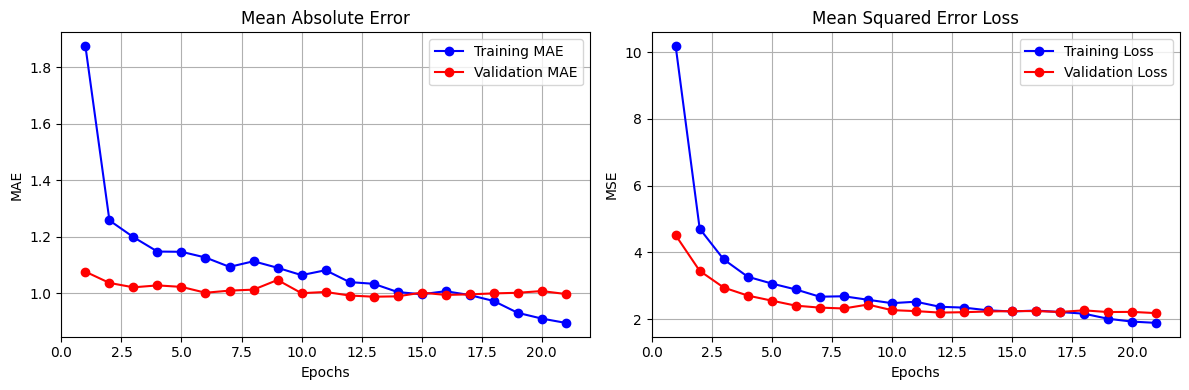

In [ ]:
plot_train_val_metrics()

## Evaluate on the test set

In [ ]:
test_mae = evaluate_test_set(
    model,
    X_prot_test, X_lig_test, y_test
)

EVALUATING MODEL ON TEST SET
Test Set Loss: 2.2216
Test Set MAE:  1.0035

Benchmark comparison:
My model MAE:        1.0035
DeepDTA MAE (pKd):   ~0.26


## Plot predictions

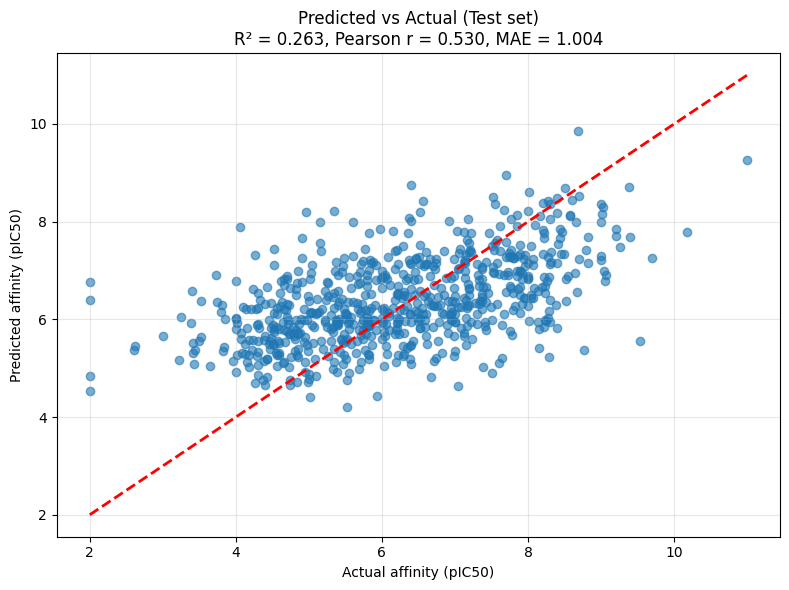

In [ ]:
plot_predictions(model, X_prot_test, X_lig_test, y_test)

## Print summary

In [ ]:
print_performance_summary()


PERFORMANCE SUMMARY
Training MAE:        0.8949
Validation MAE:      0.9876
Test MAE:            1.0035
Validation-Test Gap: 0.0160


##

## Test load from cache function - this is for small initial test purpose only

In [ ]:
import os

print("Cache dir:", cache_dir)
for f in sorted(os.listdir(cache_dir)):
    print(f)

In [ ]:
X_prot_train, prot_idx_train = load_esm2_cache(cache_dir, prefix="train")

print("Loaded protein embeddings shape:", X_prot_train.shape)
print("Loaded indices:", len(prot_idx_train))
print("Embedding dim:", X_prot_train.shape[1])

Loaded protein embeddings shape: (120, 480)
Loaded indices: 120
Embedding dim: 480


In [ ]:
X_prot_train_final, X_lig_train, y_train = build_dataset_from_cached_esm2(
    train_df,
    X_prot_train,
    prot_idx_train
)

print("Final shapes:")
print("X_prot:", X_prot_train_final.shape)
print("X_lig :", X_lig_train.shape)
print("y     :", y_train.shape)

assert X_prot_train_final.shape[0] == X_lig_train.shape[0] == y_train.shape[0]

Processing 120 ligands with Morgan fingerprints...
  Processing ligand 0/120...
  Processing ligand 100/120...
Ligand processing complete!
   Ligand fingerprints shape: (120, 2048)
   Labels shape: (120,)
   Final valid samples: 120
Final shapes:
X_prot: (120, 480)
X_lig : (120, 2048)
y     : (120,)


In [ ]:
print("Protein vector (first row):", X_prot_train_final[0][:5])
print("Ligand bits (first row):", X_lig_train[0][:10])
print("Label (first row):", y_train[0])

Protein vector (first row): [ 3.4866706e-02  7.2875500e-02  8.6734086e-05  1.2066466e-01
 -1.7298294e-02]
Ligand bits (first row): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label (first row): 5.1079054
